# Investigating Baseball Data: Batting and Pitching

The Lahman Baseball Database (available here: http://www.seanlahman.com/baseball-archive/statistics/) provides an extensive historical database of baseball statistics which I will use to answer the following interesting questions:

* Have batting averages increased or decreased over time?
* Is there a relationship between batting and pitching skills?
* Of those pitchers who bat, are pitchers good batters? 

This report uses some informal techniques (eg. exploratory data analysis) and basic statistics to find answers to these questions. 

# Part 1: Preliminaries
## 1.1 Obtain the Data


In [86]:
import urllib.request as request
request.urlretrieve('http://seanlahman.com/files/database/baseballdatabank-master_2016-03-02.zip', "baseballdatabank-master_2016-03-02.zip")

from zipfile import ZipFile
zip = ZipFile('baseballdatabank-master_2016-03-02.zip')
zip.extractall()

## 1.2 Load the Batting Data


In [87]:
import pandas as pd

batting_df = pd.read_csv("baseballdatabank-master\core\Batting.csv")
print("%d observations" % len(batting_df))

101332 observations


In [88]:
batting_df.head()

,playerID,yearID,stint,teamID,lgID,G,AB,R,H,2B,...,RBI,SB,CS,BB,SO,IBB,HBP,SH,SF,GIDP
0,abercda01,1871,1,TRO,NaN,1,4.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN
1,addybo01,1871,1,RC1,NaN,25,118.0,30.0,32.0,6.0,...,13.0,8.0,1.0,4.0,0.0,NaN,NaN,NaN,NaN,NaN
2,allisar01,1871,1,CL1,NaN,29,137.0,28.0,40.0,4.0,...,19.0,3.0,1.0,2.0,5.0,NaN,NaN,NaN,NaN,NaN
3,allisdo01,1871,1,WS3,NaN,27,133.0,28.0,44.0,10.0,...,27.0,1.0,1.0,0.0,2.0,NaN,NaN,NaN,NaN,NaN
4,ansonca01,1871,1,RC1,NaN,25,120.0,29.0,39.0,11.0,...,16.0,6.0,2.0,2.0,1.0,NaN,NaN,NaN,NaN,NaN


The data is indexed by playerID, yearID and teamID. Each entry contains the aggregate statistics for a player's stint on a team. A player can have multiple stints per year. 

## 1.3 Select columns for analysis:

To understand batting, we will look at one of the common metrics for batting ability, the batting average, which is calculated as Hits / "At Bat's". I will select the stint and the team, in addition to hits and "at bats":


In [89]:
batting_df = batting_df[['playerID', 'yearID', 'AB', 'H', 'stint', 'teamID']]
batting_df.head(5)

,playerID,yearID,AB,H,stint,teamID
0,abercda01,1871,4.0,0.0,1,TRO
1,addybo01,1871,118.0,32.0,1,RC1
2,allisar01,1871,137.0,40.0,1,CL1
3,allisdo01,1871,133.0,44.0,1,WS3
4,ansonca01,1871,120.0,39.0,1,RC1



## 1.4 Calculate Batting Average

In [90]:
batting_df['batting_average'] = batting_df['H'] / batting_df['AB']
batting_df.head(5)

,playerID,yearID,AB,H,stint,teamID,batting_average
0,abercda01,1871,4.0,0.0,1,TRO,0.000000
1,addybo01,1871,118.0,32.0,1,RC1,0.271186
2,allisar01,1871,137.0,40.0,1,CL1,0.291971
3,allisdo01,1871,133.0,44.0,1,WS3,0.330827
4,ansonca01,1871,120.0,39.0,1,RC1,0.325000


## 1.5 Examine the Distribution

We will look at the distribution of data to see if we notice any interesting anything interesting. First, we look at the distribution of batting averages, which we plot below in the density plot.

In [91]:
batting_df = batting_df.dropna() # Drop missing values
batting_df['batting_average'].dropna().describe()

count    86410.000000
mean         0.209025
std          0.122313
min          0.000000
25%          0.147541
50%          0.230769
75%          0.274434
max          1.000000
Name: batting_average, dtype: float64

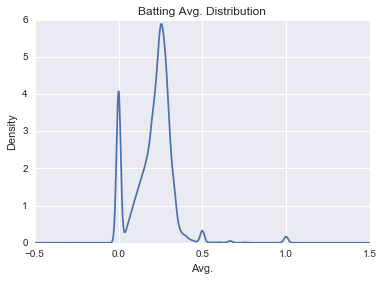

In [92]:
import matplotlib.pyplot as plt
import seaborn
%matplotlib inline

# Plot the distribution
batting_df['batting_average'].plot.kde()
plt.title("Batting Avg. Distribution")
plt.xlabel("Avg.")
plt.show()

This is an interesting distribution. It doesn't quite look normal, as quite a few batters have zero averages. Also, there are a few with unusually high averages (50% and 100%). 

## 1.6 Exploratory Analyis: Batting Average over time

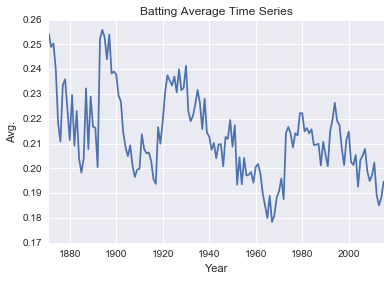

In [93]:
batting_df.groupby('yearID')['batting_average'].mean().plot()
plt.title("Batting Average Time Series")
plt.xlabel("Year")
plt.ylabel("Avg.")
plt.show()

There are some interesting changes in batting average over time. There was a spike leading up to the 1890's, followed by a steep decline, then a couple spikes leading up to a peak in the 1920's, followed by a long, slow decline into the 1960's. After that batting averages trended up into the 80's and to year 2000. We might want to explore why this happened using other data in our data set, but that is outside the scope of this initial investigation.

# Part 2: Batting Skills vs. Pitching Skills

Pitching skill is measured by a few different stats, but one of the most common is Earned Run Average, or ERA. The ERA is calculated as the number of Earned Runs divided by the number of innings pitched. The definition of "Earned Run" is rather long. In short, it is a run for which the pitcher is held accountable (See http://www.baseball-almanac.com/rule10.shtml#anchor11198 for the full definition).

The variable "IPouts" is the number of innings pitched times 3. We can get the number of innings pitched simply by dividing this number by 3.

For batting, we refer to the batting average, although there are other statistics we could consider. For brevity, I just use the batting average we calculated above

## 2.1 Get Pitching Data

In [94]:
import pandas as pd
pitching_df = pd.read_csv("baseballdatabank-master\core\Pitching.csv")

## 2.2 Calculate Earned Run Average 

In [95]:
pitching_df['innings_pitched'] = pitching_df['IPouts'] / 3
pitching_df['ERA'] = pitching_df['ER'] / pitching_df['innings_pitched'] * 9
pitching_df = pitching_df[['playerID', 'yearID', 'stint', 'teamID', 'IPouts', 'ER', 'ERA', 'innings_pitched']]
pitching_df.head()

,playerID,yearID,stint,teamID,IPouts,ER,ERA,innings_pitched
0,bechtge01,1871,1,PH1,78.0,23,7.961538,26.0
1,brainas01,1871,1,WS3,792.0,132,4.500000,264.0
2,fergubo01,1871,1,NY2,3.0,3,27.000000,1.0
3,fishech01,1871,1,RC1,639.0,103,4.352113,213.0
4,fleetfr01,1871,1,NY2,27.0,10,10.000000,9.0


In [96]:
pitching_df = pitching_df.dropna() # Drop missing values
pitching_df.describe()

,yearID,stint,IPouts,ER,ERA,innings_pitched
count,44083.000000,44083.000000,44083.000000,44083.000000,4.408300e+04,44083.000000
mean,1967.818547,1.079305,255.992877,36.367171,inf,85.330959
std,37.345478,0.284530,258.432048,33.532416,NaN,86.144016
min,1871.000000,1.000000,0.000000,0.000000,0.000000e+00,0.000000
25%,1940.000000,1.000000,50.000000,9.000000,3.151867e+00,16.666667
50%,1977.000000,1.000000,169.000000,25.000000,4.133201e+00,56.333333
75%,2000.000000,1.000000,398.000000,58.000000,5.500000e+00,132.666667
max,2015.000000,4.000000,2040.000000,291.000000,inf,680.000000


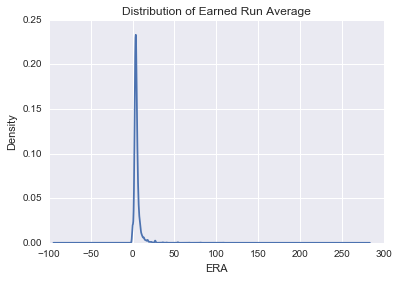

In [97]:
import numpy as np
pitching_df[np.isfinite(pitching_df['ERA'])]['ERA'].plot.kde()
plt.title('Distribution of Earned Run Average')
plt.xlabel('ERA')
plt.show()

In the above plot, there is a wide range of values, but most observations are between 0 and 5. A "good" ERA is below 4. Between 4 and 5 is OK, but not great. Over 5 is considered unsustainable, as a pitcher with this ERA will likely be replaced.

For this analysis, I am interested in all skill levels. Like the batters, some of these pitchers have exceptionally good or bad metrics, mostly due to a small number of games pitched. For the scatterplot below, I've included those outliers. In addition, I will re-load the batters and include those batters with few at bats. Skills are likely correlated with the number of attempts, as players who perform poorly will be given fewer opportunities.

## 2.3 Merge Pitching and Batting 

In [98]:
players_df = pd.merge(pitching_df, batting_df, on="playerID", how="inner")
players_df = players_df[players_df['AB'] > 0] # Require at least 1 at bat
players_df = players_df[players_df['innings_pitched'] > 0] # Eliminate no innings pitched
players_df.describe()

,yearID_x,stint_x,IPouts,ER,ERA,innings_pitched,yearID_y,AB,H,stint_y,batting_average
count,293349.000000,293349.000000,293349.000000,293349.000000,293349.000000,293349.000000,293349.000000,293349.000000,293349.000000,293349.000000,293349.000000
mean,1960.175388,1.094004,348.658294,47.278054,4.509170,116.219431,1960.014955,47.119540,9.470787,1.084981,0.155586
std,36.460243,0.310533,288.233776,36.160656,4.086795,96.077925,36.241361,72.287087,20.223755,0.296325,0.142753
min,1871.000000,1.000000,1.000000,0.000000,0.000000,0.333333,1871.000000,1.000000,0.000000,1.000000,0.000000
25%,1932.000000,1.000000,100.000000,16.000000,3.037500,33.333333,1932.000000,5.000000,1.000000,1.000000,0.052632
50%,1964.000000,1.000000,278.000000,40.000000,3.866348,92.666667,1964.000000,26.000000,4.000000,1.000000,0.148936
75%,1993.000000,1.000000,567.000000,75.000000,4.948956,189.000000,1993.000000,65.000000,11.000000,1.000000,0.221053
max,2015.000000,4.000000,2040.000000,291.000000,189.000000,680.000000,2015.000000,704.000000,262.000000,4.000000,1.000000


## 2.4 Pitching vs. Batting

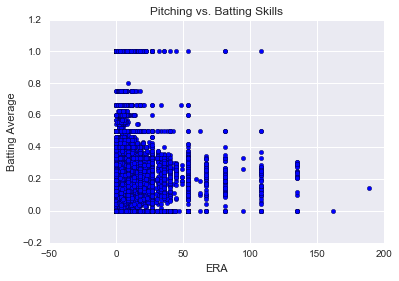

In [99]:
plt.scatter(players_df['ERA'], players_df['batting_average'])
plt.title('Pitching vs. Batting Skills')
plt.xlabel('ERA')
plt.ylabel('Batting Average')
plt.show()


Most of the values are clustered between 0 to 10.0 ERA, and 0 to 0.4 batting average. It is hard to discern any clear relationship between great batting averages and pitching skill using this plot. Also, we see quite a few outliers. 

# Part 3: Are Pitchers Good Batters?

The "Designated Hitter" rule allows a team to use one non-fielding player as a batter, typically in place of the pitcher. This rule was introduced in 1973 in the American League. In the Lahmann database, Appearances.G_dh is the number of games as designated hitter. 

The common understanding is that pitchers are not typically good at batting. This makes me curious: can we quantify how poorly pitchers perform in comparison to other players at batting?
    
To compare their respective batting skills, we will divide the batters into two groups -- those who have pitched, and those who haven't. 


## 3.1 Remove Anomalous Data

Some of these values should not be included in analysis because they're not representative of the populations we want to compare. For example, some players that batted relatively few times had unusually low or high averages. There is a disproportionate number of such entries in the Batting data, as we saw in section 1.5, which skews the distribution. We will throw those values out:


In [100]:
players_df = players_df[players_df['AB'] > 20]
batting_df = batting_df[batting_df['AB'] > 20]

## 3.2 Subset Batters

In [101]:
# Population 1: Pitchers that also bat
pitchers_that_bat = players_df[players_df['innings_pitched'] > 0.0]
pitchers_that_bat_grouped_by_playerID = pitchers_that_bat.groupby('playerID', as_index=False)
batting_averages_for_pitchers = pitchers_that_bat_grouped_by_playerID.sum()['H'] / pitchers_that_bat_grouped_by_playerID.sum()['AB']
print("Batting pitchers: %d" % len(batting_averages_for_pitchers))

# Population 2: All other batters
non_pitching_batters = batting_df[~batting_df['playerID'].isin(pitchers_that_bat['playerID'])]
non_pitching_batters = non_pitching_batters[non_pitching_batters['AB'] > 20]
non_pitching_batters_grouped_by_playerID = non_pitching_batters.groupby('playerID', as_index=False)
batting_averages_for_non_pitchers = non_pitching_batters_grouped_by_playerID.sum()['H'] / non_pitching_batters_grouped_by_playerID.sum()['AB']
print("All other batters: %d" % len(batting_averages_for_non_pitchers))


Batting pitchers: 3605
All other batters: 7604


## 3.3 Compare means

We look at the mean batting average for pitchers that bat vs. all other batters:

In [102]:
batting_averages_for_pitchers.mean()

0.17646337747863064

In [103]:
batting_averages_for_non_pitchers.mean()

0.24171744728662461

It does appear, at first blush, that pitchers are worse at batting based on the means we calculated for both groups. We can use a t-test to test the null hypothesis that batting pitchers bat no better or worse than all other batters.

The t-test assumes a normal distribution. Recall that we observed outliers in the baseball averages due to players that infrequently batted and had either very low or very high batting averages. Similarly, some pitchers pitched few innings. We removed those outliers in section 3.1 in order to get a more accurate confidence interval for the t-test:


## 3.4 Hypothesis Test

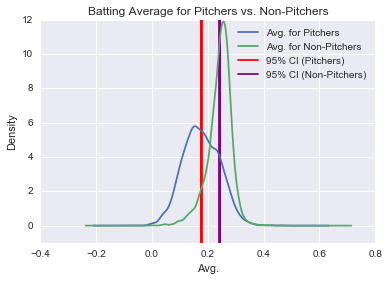

In [115]:
stderr = st.sem(batting_averages_for_pitchers)
interval1 = (batting_averages_for_pitchers.mean() - stderr * 1.96, batting_averages_for_pitchers.mean() + stderr * 1.96)

stderr = st.sem(batting_averages_for_non_pitchers)
interval2 = (batting_averages_for_non_pitchers.mean() - stderr * 1.96, batting_averages_for_non_pitchers.mean() + stderr * 1.96)

batting_averages_for_pitchers.plot.kde(label='Avg. for Pitchers')
ax = batting_averages_for_non_pitchers.plot.kde(label='Avg. for Non-Pitchers')

ax.vlines(x=batting_averages_for_pitchers.mean(), ymin=-1, ymax=15, color='red', label='95% CI (Pitchers)')
ax.vlines(x=interval1[0], ymin=-1, ymax=15, color='red')
ax.vlines(x=interval1[1], ymin=-1, ymax=15, color='red')

ax.vlines(x=batting_averages_for_non_pitchers.mean(), ymin=-1, ymax=15, color='purple', label='95% CI (Non-Pitchers)')
ax.vlines(x=interval2[0], ymin=-1, ymax=15, color='purple')
ax.vlines(x=interval2[1], ymin=-1, ymax=15, color='purple')

ax.set_ylim([-1,12])
ax.legend()

plt.title("Batting Average for Pitchers vs. Non-Pitchers")
plt.xlabel("Avg.")
plt.show()

We see that the confidence intervals for the mean batting average of each population do not overlap. We will confirm this with a t-test below:

In [105]:
import scipy.stats

scipy.stats.ttest_ind(batting_averages_for_pitchers, batting_averages_for_non_pitchers, equal_var=False)

Ttest_indResult(statistic=-55.096744835892814, pvalue=0.0)

Since the p-value is very small, we can reject the null hypothesis. The mean batting average for pitchers is clearly lower than the mean batting average for all other players.